# Lecture 2
<br>
<br>

You can find a copy of this presentation at

https://github.com/grossiM/LAB_Quantum_Computation22/tree/main


michele.grossi@cern.ch

# Noise

This tutorial introduces how to use the Qiskit Aer `noise` module to build custom noise models for noisy simulations.

<img src="new_images/noise_model_picture.PnG">

In [1]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

In [2]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

## Qiskit Aer Noise Module

The Qiskit Aer `noise` module contains Python classes to build customized noise models for simulation. There are three key classes:

1. The `NoiseModel` class which stores a noise model used for noisy simulation.
2. The `QuantumError` class which describes CPTP gate errors. These can be applied:
    * After *gate* or *reset* instructions
    * Before *measure* instructions.

3. The `ReadoutError` class which describes classical readout errors.

## Quantum Errors

Rather than deal with the `QuantumError` object directly, many helper functions exist to automatically generate a specific type of parameterized quantum error. These are contained in the `noise` module and include functions for many common errors types used in quantum computing research. The function names and the type of error they return are:

| Standard error function | Details |
| --- | --- |
| `kraus_error` | a general n-qubit CPTP error channel given as a list of Kraus matrices $[K_0, ...]$. |
| `mixed_unitary_error` | an n-qubit mixed unitary error given as a list of unitary matrices and probabilities $[(U_0, p_0),...]$. |
| `coherent_unitary_error` | an n-qubit coherent unitary error given as a single unitary matrix $U$. |
| `pauli_error` | an n-qubit Pauli error channel (mixed unitary) given as a list of Pauli's and probabilities $[(P_0, p_0),...]$ |
| `depolarizing_error` | an n-qubit depolarizing error channel parameterized by a depolarization probability $p$. |
| `reset_error` | a single-qubit reset error parameterized by a probabilities $p_0, p_1$ of resetting to the $|0\rangle$, $|1\rangle$ state.|
| `thermal_relaxation_error` | a single qubit thermal relaxation channel parameterized by relaxation time constants $T_1$, $T_2$, gate time $t$, and excited state thermal population $p_1$. |
| `phase_amplitude_damping_error` | A single-qubit generalized combined phase and amplitude damping error channel given by an amplitude damping parameter $\lambda$, a phase damping parameter $\gamma$, and an excited state thermal population $p_1$. |
| `amplitude_damping_error` |  A single-qubit generalized amplitude damping error channel given by an amplitude damping parameter $\lambda$, and an excited state thermal population $p_1$. |
| `phase_damping_error` |  A single-qubit phase damping error channel given by a phase damping parameter $\gamma$ |

### Combining quantum errors

`QuantumError` instances can be combined by using composition, tensor product, and tensor expansion (reversed order tensor product) to produce new `QuantumErrors` as:

 * Composition: $\cal{E}(\rho)=\cal{E_2}(\cal{E_1}(\rho))$ as `error = error1.compose(error2)`
 * Tensor product: $\cal{E}(\rho) =(\cal{E_1}\otimes\cal{E_2})(\rho)$ as `error error1.tensor(error2)`
 * Expand product: $\cal{E}(\rho) =(\cal{E_2}\otimes\cal{E_1})(\rho)$ as `error error1.expand(error2)`

### Example

For example to construct a 3% single-qubit Bit-flip error:

In [3]:
# Construct a 1-qubit bit-flip and phase-flip errors
p_error = 0.03
bit_flip = pauli_error([('X', p_error), ('I', 1 - p_error)])
phase_flip = pauli_error([('Z', p_error), ('I', 1 - p_error)])
print(bit_flip)
print(phase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.03, Circuit = 
   ┌───┐
q: ┤ X ├
   └───┘
  P(1) = 0.97, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘
QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.03, Circuit = 
   ┌───┐
q: ┤ Z ├
   └───┘
  P(1) = 0.97, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘


In [4]:
# Compose two bit-flip and phase-flip errors
bitphase_flip = bit_flip.compose(phase_flip)
print(bitphase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.0009, Circuit = 
   ┌───┐┌───┐
q: ┤ X ├┤ Z ├
   └───┘└───┘
  P(1) = 0.029099999999999997, Circuit = 
   ┌───┐┌───┐
q: ┤ X ├┤ I ├
   └───┘└───┘
  P(2) = 0.029099999999999997, Circuit = 
   ┌───┐┌───┐
q: ┤ I ├┤ Z ├
   └───┘└───┘
  P(3) = 0.9409, Circuit = 
   ┌───┐┌───┐
q: ┤ I ├┤ I ├
   └───┘└───┘


### Converting to and from QuantumChannel operators
 
We can also convert back and forth between `QuantumError` objects in Qiskit Aer and `QuantumChannel` objects in Qiskit Terra.

In [5]:
# Convert to Kraus operator
bit_flip_kraus = Kraus(bit_flip)
print(bit_flip_kraus)

Kraus([[[ 0.98488578+0.j,  0.        +0.j],
        [ 0.        +0.j,  0.98488578+0.j]],

       [[ 0.        +0.j, -0.17320508+0.j],
        [-0.17320508+0.j,  0.        -0.j]]],
      input_dims=(2,), output_dims=(2,))


In [6]:
# Convert to Superoperator
phase_flip_sop = SuperOp(phase_flip)
print(phase_flip_sop)

SuperOp([[1.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j],
         [0.  +0.j, 0.94+0.j, 0.  +0.j, 0.  +0.j],
         [0.  +0.j, 0.  +0.j, 0.94+0.j, 0.  +0.j],
         [0.  +0.j, 0.  +0.j, 0.  +0.j, 1.  +0.j]],
        input_dims=(2,), output_dims=(2,))


In [7]:
# Convert back to a quantum error
print(QuantumError(bit_flip_kraus))

# Check conversion is equivalent to original error
QuantumError(bit_flip_kraus) == bit_flip

QuantumError on 1 qubits. Noise circuits:
  P(0) = 1.0, Circuit = 
   ┌───────┐
q: ┤ kraus ├
   └───────┘


True

### Readout Error

Classical readout errors are specified by a list of assignment probabilities vectors $P(A|B)$:

  * $A$ is the *recorded* classical bit value
  * $B$ is the *true* bit value returned from the measurement 
 
E.g. for 1 qubits: $ P(A|B) = [P(A|0), P(A|1)]$.

In [ ]:
# Measurement miss-assignement probabilities
p0given1 = 0.1
p1given0 = 0.05

ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])

## Adding errors to a Noise Model

When adding a quantum error to a noise model we must specify the type of *instruction* that it acts on, and what qubits to apply it to. There are three cases for Quantum Errors:
 
 1. All-qubit quantum error
 2. Specific qubit quantum error
 3. Non-local quantum error
 
### All-qubit quantum error

This applies the same error to any occurrence of an instruction, regardless of which qubits it acts on.

It is added as `noise_model.add_all_qubit_quantum_error(error, instructions)`:

In [8]:
# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates
error = depolarizing_error(0.05, 1)
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])

# Print noise model info
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'u2', 'u3']
  All-qubits errors: ['u1', 'u2', 'u3']


### Specific qubit quantum error

This applies the error to any occurrence of an instruction acting on a specified list of qubits. Note that the order of the qubit matters: For a 2-qubit gate an error applied to qubits [0, 1] is different to one applied to qubits [1, 0] for example.

It is added as `noise_model.add_quantum_error(error, instructions, qubits)`:

In [9]:
# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates on qubit 0 only
error = depolarizing_error(0.05, 1)
noise_model.add_quantum_error(error, ['u1', 'u2', 'u3'], [0])

# Print noise model info
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'u2', 'u3']
  Qubits with noise: [0]
  Specific qubit errors: [('u1', (0,)), ('u2', (0,)), ('u3', (0,))]


### Non-local qubit quantum error

This applies an error to a specific set of noise qubits after any occurrence of an instruction acting on a specific of gate qubits.

It is added as `noise_model.add_nonlocal_quantum_error(error, instructions, instr_qubits, error_qubits)`:

In [10]:
# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error on qubit 2 forall single qubit u1, u2, u3 gates on qubit 0 
error = depolarizing_error(0.05, 1)
noise_model.add_nonlocal_quantum_error(error, ['u1', 'u2', 'u3'], [0], [2])

# Print noise model info
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'u2', 'u3']
  Qubits with noise: [0, 2]
  Non-local specific qubit errors: [('u1', (0,), (2,)), ('u2', (0,), (2,)), ('u3', (0,), (2,))]


### Executing a noisy simulation with a noise model

The command `AerSimulator(noise_model=noise_model)` returns a simulator configured to the given noise model. In addition to setting the simulator's noise model, it also overrides the simulator's basis gates, according to the gates of the noise model.

We will now try some examples of noise models. For our demonstrations we will use a simple test circuit generating a n-qubit GHZ state:

In [11]:
# System Specification
n_qubits = 4
circ = QuantumCircuit(n_qubits)

# Test Circuit
circ.h(0)
for qubit in range(n_qubits - 1):
    circ.cx(qubit, qubit + 1)
circ.measure_all()
print(circ)

        ┌───┐                ░ ┌─┐         
   q_0: ┤ H ├──■─────────────░─┤M├─────────
        └───┘┌─┴─┐           ░ └╥┘┌─┐      
   q_1: ─────┤ X ├──■────────░──╫─┤M├──────
             └───┘┌─┴─┐      ░  ║ └╥┘┌─┐   
   q_2: ──────────┤ X ├──■───░──╫──╫─┤M├───
                  └───┘┌─┴─┐ ░  ║  ║ └╥┘┌─┐
   q_3: ───────────────┤ X ├─░──╫──╫──╫─┤M├
                       └───┘ ░  ║  ║  ║ └╥┘
meas_0: ════════════════════════╩══╬══╬══╬═
                                   ║  ║  ║ 
meas_1: ═══════════════════════════╩══╬══╬═
                                      ║  ║ 
meas_2: ══════════════════════════════╩══╬═
                                         ║ 
meas_3: ═════════════════════════════════╩═
                                           


### Ideal Simulation


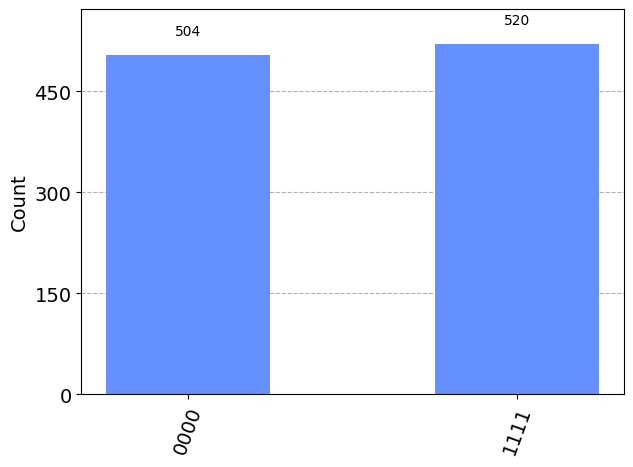

In [12]:
sim_ideal = AerSimulator()
result_ideal = sim_ideal.run(circ).result()
plot_histogram(result_ideal.get_counts(0))

## Noise Example 1: Basic bit-flip error noise model

Lets consider a simple toy noise model example common in quantum information theory research:

* When applying a single qubit gate, flip the state of the qubit with probability `p_gate1`.
* When applying a 2-qubit gate apply single-qubit errors to each qubit.
* When resetting a qubit reset to 1 instead of 0 with probability `p_reset`.
* When measuring a qubit, flip the state of the qubit with probability `p_meas`.

In [14]:
# Example error probabilities
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

print(noise_bit_flip)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['reset', 'measure', 'u1', 'u3', 'cx', 'u2']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


### Executing the noisy simulation

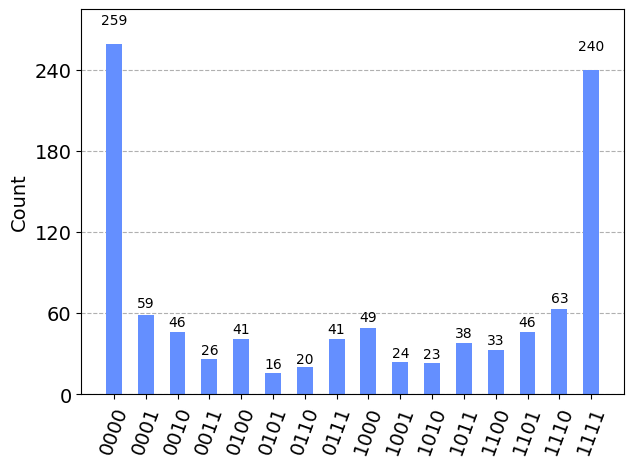

In [15]:
# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_bit_flip)

# Transpile circuit for noisy basis gates
circ_tnoise = transpile(circ, sim_noise)

# Run and get counts
result_bit_flip = sim_noise.run(circ_tnoise).result()
counts_bit_flip = result_bit_flip.get_counts(0)

# Plot noisy output
plot_histogram(counts_bit_flip)

## Device backend noise model simulations
Here we show how to use the Qiskit Aer `noise` module to automatically generate a basic noise model for an IBMQ hardware device, and use this model to do noisy simulations of `QuantumCircuits` to study the effects of errors which occur on real devices.

Note, that these automatic models are only an *approximation* of the real errors that occur on actual devices, due to the fact that they must be build from a limited set of input parameters related to *average error rates* on gates. The study of quantum errors on real devices is an active area of research and we discuss the Qiskit Aer tools for configuring more detailed noise models in another notebook.



## Device Backend Noise Model

The *Qiskit Aer* device noise model automatically generates a simplified noise model for a real device. This model is generated using the calibration information reported in the `BackendProperties` of a device and takes into account

* The *gate_error* probability of each basis gate on each qubit.
* The *gate_length* of each basis gate on each qubit.
* The $T_1$, $T_2$ relaxation time constants of each qubit.
* The readout error probability of each qubit.

### Terra Mock  Backends

We will use real noise data for an IBM Quantum device using the data stored in Qiskit Terra. Specifically, in this tutorial, the device is `ibmq_vigo`.




In [16]:
from qiskit import IBMQ, transpile
from qiskit.test.mock import FakeGeneva, FakeGeneva
device_backend = FakeGeneva()

/var/folders/sm/1d0rxbz57bx0_9fjrdq9bf9m0000gn/T/ipykernel_10675/2824264103.py:2: DeprecationWarning: The module 'qiskit.test.mock' is deprecated since Qiskit Terra 0.21.0, and will be removed 3 months or more later. Instead, you should import the desired object directly 'qiskit.providers.fake_provider'.
  from qiskit.test.mock import FakeGeneva, FakeGeneva


In [17]:
#https://qiskit.org/documentation/_modules/qiskit/providers/fake_provider/fake_provider.html
from qiskit.providers.fake_provider import FakeGeneva, FakeVigo
device_backend = FakeVigo()

### Test circuit for device and simulation comparison

Now we construct a test circuit to compare the output of the real device with the noisy output simulated on the Qiskit Aer `AerSimulator`. We will prepare a 3-qubit GHZ state $\frac{1}{\sqrt2}(|0,0,0\rangle + |1,1,1\rangle)$ on qubits 0, 1 and 2. Before running with noise or on the device we show the ideal expected output with no noise.

/opt/homebrew/Caskroom/miniforge/base/envs/qiskit_trieste22/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/Caskroom/miniforge/base/envs/qiskit_trieste22/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


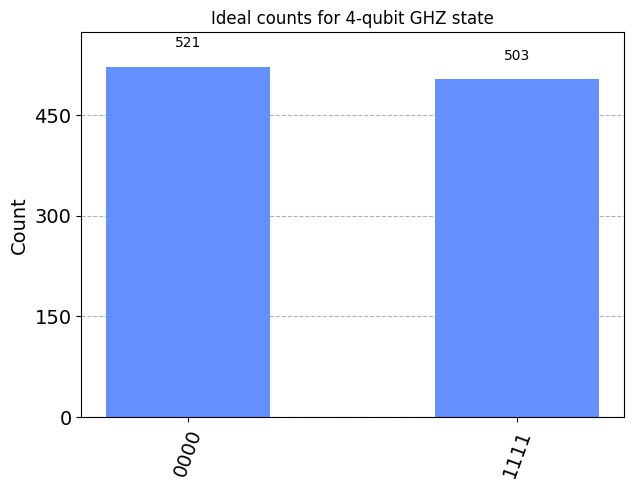

In [21]:
# Construct quantum circuit
circ = QuantumCircuit(4, 4)
circ.h(0)
circ.cx(0, 1)
circ.cx(1, 2)
circ.cx(2,3)
circ.measure([0, 1, 2,3], [0, 1, 2,3])

sim_ideal = AerSimulator()

# Execute and get counts
result = sim_ideal.run(transpile(circ, sim_ideal)).result()
counts = result.get_counts(0)
plot_histogram(counts, title='Ideal counts for 4-qubit GHZ state')

Let's generate a simulator that mimics a device

In [19]:
#Be aware that v2 backend are not supported
sim_vigo = AerSimulator.from_backend(device_backend)

By storing the device properties in `vigo_simulator`, we ensure that the appropriate basis gates and coupling map are used when compiling circuits for simulation, thereby most closely mimicking the gates that will be executed on a real device. In addition `vigo_simulator` contains an approximate noise model consisting of:

* **Single-qubit gate errors** consisting of a single qubit depolarizing error followed by a single qubit thermal relaxation error.
* **Two-qubit gate errors** consisting of a two-qubit depolarizing error followed by single-qubit thermal relaxation errors on both qubits in the gate.
* **Single-qubit readout errors** on the classical bit value obtained from measurements on individual qubits.

For the gate errors the error parameter of the thermal relaxation errors is derived using the `thermal_relaxation_error` function from `aer.noise.errors` module, along with the individual qubit $T_1$ and $T_2$ parameters, and the `gate_time` parameter from the device backend properties. The probability of the depolarizing error is then set so that the combined average gate infidelity from the depolarizing error followed by the thermal relaxation is equal to the `gate_error` value from the backend properties.

For the readout errors the probability that the recorded classical bit value will be flipped from the true outcome after a measurement is given by the qubit `readout_errors`.

**Important:** When running noisy simulations it is *critical* to `transpile` the circuit for the backend so that the circuit is transpiled to the correct noisy basis gate set for the backend. If transpilation is skipped noise from the device noise model will not be applied to gates in the circuit that are supported by the simulator, but not supported by the mimicked backend.

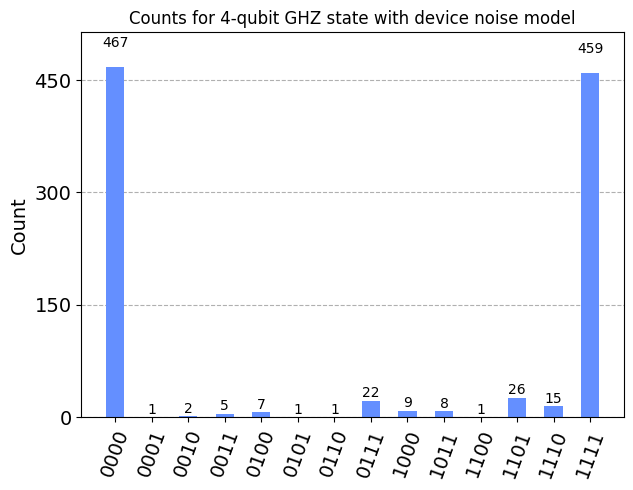

In [22]:
# Transpile the circuit for the noisy basis gates
tcirc = transpile(circ, sim_vigo)

# Execute noisy simulation and get counts
result_noise = sim_vigo.run(tcirc).result()
counts_noise = result_noise.get_counts(0)
plot_histogram(counts_noise,
               title="Counts for 4-qubit GHZ state with device noise model")

## Mitigating readout errors 

The qiskit experiment package also has measurement filters that can be used to mitigate various types of errors, such as ****measurements and tensors****.
The `measurement calibration` is what we will use to mitigate measurement errors in this section. The process begins by first generating a list of circuits, where each circuit represents each of all the possible states of the qubits specified, then executing the circuits on an ideal simulator, the results of which we will then pass into a measurement filter. The `measurement filter` will then be used to mitigate the measurement errors.

The process of measurement error mitigation can also be done using tools from Qiskit. This handles the collection of data for the basis states, the construction of the matrices and the calculation of the inverse. The latter can be done using the pseudo inverse, as we saw above. However, the default is an even more sophisticated method using least squares fitting.

In [23]:
from qiskit.utils.mitigation import complete_meas_cal, CompleteMeasFitter

In [34]:
from qiskit import QuantumRegister
qr = QuantumRegister(4)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
for circuit in meas_calibs:
    print('Circuit',circuit.name)
    print(circuit)
    print()

Circuit mcalcal_0000
         ░ ┌─┐         
q109_0: ─░─┤M├─────────
         ░ └╥┘┌─┐      
q109_1: ─░──╫─┤M├──────
         ░  ║ └╥┘┌─┐   
q109_2: ─░──╫──╫─┤M├───
         ░  ║  ║ └╥┘┌─┐
q109_3: ─░──╫──╫──╫─┤M├
         ░  ║  ║  ║ └╥┘
  c1_0: ════╩══╬══╬══╬═
               ║  ║  ║ 
  c1_1: ═══════╩══╬══╬═
                  ║  ║ 
  c1_2: ══════════╩══╬═
                     ║ 
  c1_3: ═════════════╩═
                       

Circuit mcalcal_0001
        ┌───┐ ░ ┌─┐         
q109_0: ┤ X ├─░─┤M├─────────
        └───┘ ░ └╥┘┌─┐      
q109_1: ──────░──╫─┤M├──────
              ░  ║ └╥┘┌─┐   
q109_2: ──────░──╫──╫─┤M├───
              ░  ║  ║ └╥┘┌─┐
q109_3: ──────░──╫──╫──╫─┤M├
              ░  ║  ║  ║ └╥┘
  c1_0: ═════════╩══╬══╬══╬═
                    ║  ║  ║ 
  c1_1: ════════════╩══╬══╬═
                       ║  ║ 
  c1_2: ═══════════════╩══╬═
                          ║ 
  c1_3: ══════════════════╩═
                            

Circuit mcalcal_0010
              ░ ┌─┐         
q109_

In [35]:
# Execute the calibration circuits without noise
from qiskit import Aer, assemble

aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(meas_calibs, aer_sim)
qobj = assemble(t_qc, shots=10000)
cal_results = aer_sim.run(qobj, shots=10000).result()

In [36]:
##IDEAL Matrix
from qiskit.visualization import array_to_latex

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
array_to_latex(meas_fitter.cal_matrix)

<IPython.core.display.Latex object>

In [37]:
t_qc = transpile(meas_calibs, sim_vigo)

qobj = assemble(t_qc, shots=10000)
#cal_results = sim_vigo.run(qobj, noise_model=noise_model, shots=10000).result()
cal_results = sim_vigo.run(qobj, shots=10000).result()


meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
array_to_latex(meas_fitter.cal_matrix)

<IPython.core.display.Latex object>

In [38]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(result_noise)
mitigated_counts = mitigated_results.get_counts()

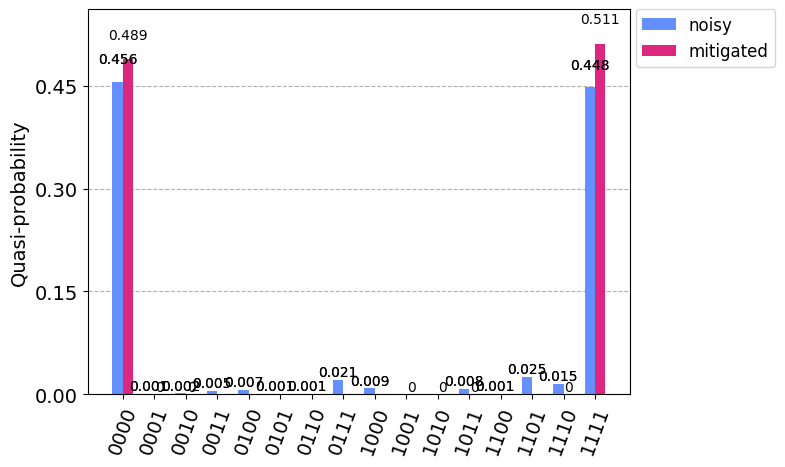

In [39]:
from qiskit.visualization import plot_histogram 

plot_histogram([counts_noise, mitigated_counts], legend=['noisy', 'mitigated'])